# **Update the dataset**

### Import libraries

In [ ]:
import pandas as pd


### Read the dataset

In [ ]:
data = pd.read_csv('/content/Merged_all.csv')

### Create new columns for longitude and latitude in km

In [ ]:
data['Longitude_km'] = data['ADJ_LONGITUDE'] * 111    # Assuming 1 degree of longitude is approximately 111 km
data['Latitude_km'] = data['ADJ_LATITUDE'] * 111      # Assuming 1 degree of latitude is approximately 111 km

### Drop first two columns

In [ ]:
data = data.drop(['ADJ_LONGITUDE', 'ADJ_LATITUDE'], axis=1)

### Print the updated dataset

In [ ]:
print(data)

          CELL_KEY_H  MEAN_RSRP  INSTANCE_COUNT  CELL_AZIMUTH  Longitude_km  \
0       3.518017e+09 -83.333333            48.0         215.0      0.523254   
1       3.518017e+09 -85.518519            75.0         215.0      0.181152   
2       3.518017e+09 -87.120000           969.0         215.0      0.060384   
3       3.518017e+09 -85.454054           544.0         215.0      0.000000   
4       3.518017e+09 -90.631579            20.0         215.0      0.221445   
...              ...        ...             ...           ...           ...   
192505  4.060000e+09 -89.000000             1.0         230.0      0.316350   
192506  4.060000e+09 -84.700000             5.0         230.0      0.397380   
192507  4.060000e+09 -72.000000             2.0         230.0      0.558330   
192508  4.060000e+09 -78.000000             1.0         230.0      1.809300   
192509  4.060000e+09 -92.000000             1.0         230.0      0.799200   

        Latitude_km  
0          0.854367  
1      

# **Model building and training**

### Import libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


### Prepare the input features (X) and target variable (y)

making cell key categorical

In [ ]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
data['CELL_KEY_H'] = data['CELL_KEY_H'].astype('category')
# Fit and transform the label encoder on the 'CELL_KEY_H' column
data['CELL_KEY_H'] = le.fit_transform(data['CELL_KEY_H'])

# Now 'CELL_KEY_H' is a categorical variable with numerical labels



In [ ]:
# Now, you need to set your X and y based on the updated DataFrame
X = data.drop(['CELL_AZIMUTH'], axis=1)  # Drop the target variable
y = data['CELL_AZIMUTH']

### Split the dataset into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Create a random forest regression model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150]}


In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=param_grid, random_state=42)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 100}


### Train the random forest model

In [ ]:
# Extract the best number of estimators from the best_params dictionary
best_n_estimators = best_params['n_estimators']

# Create a new random forest regressor with the best number of estimators
rf_regressor = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# **Evaluate the training and testing sets**

### Import libraries

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

### Predict on both training and testing data

In [ ]:
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

### Calculate evaluation metrics on training and testing data


In [ ]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

### Print the evaluation metrics

In [ ]:
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)
print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

Training Mean Squared Error: 8.324812737000677
Testing Mean Squared Error: 50.39890109604696
Training R-squared: 0.9990262594034838
Testing R-squared: 0.9941724509945424


# **Model accuracy**

### Calculate the R-squared score


In [ ]:
r2_score_percentage = r2_score(y_test, y_test_pred) * 100

### Print the model's accuracy


In [ ]:
print("Model Accuracy (R-squared): {:.2f}%".format(r2_score_percentage))

Model Accuracy (R-squared): 99.42%


# **Overfitting/Underfitting?**

### Import the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

###  Initialize a list to store training and testing errors


In [ ]:
train_errors = []
test_errors = []

### Define a range of training set sizes


In [ ]:
training_sizes = np.linspace(0.1, 1.0, 10, endpoint=True)

### Initiate a loop that will iterate through each of the 10 values in 'training_sizes'

In [ ]:
for size in training_sizes:
    # Calculate the number of samples based on the fraction of training data
    num_samples = int(len(X_train) * size)

    # Create a random forest regression model
    rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)

    # Fit the model to the training data
    rf_regressor.fit(X_train[:num_samples], y_train[:num_samples])

    # Predict on both training and testing data
    y_train_pred = rf_regressor.predict(X_train)
    y_test_pred = rf_regressor.predict(X_test)

    # Calculate Mean Squared Error for training and testing data
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Append errors to the lists
    train_errors.append(train_mse)
    test_errors.append(test_mse)

### Plot the learning curve


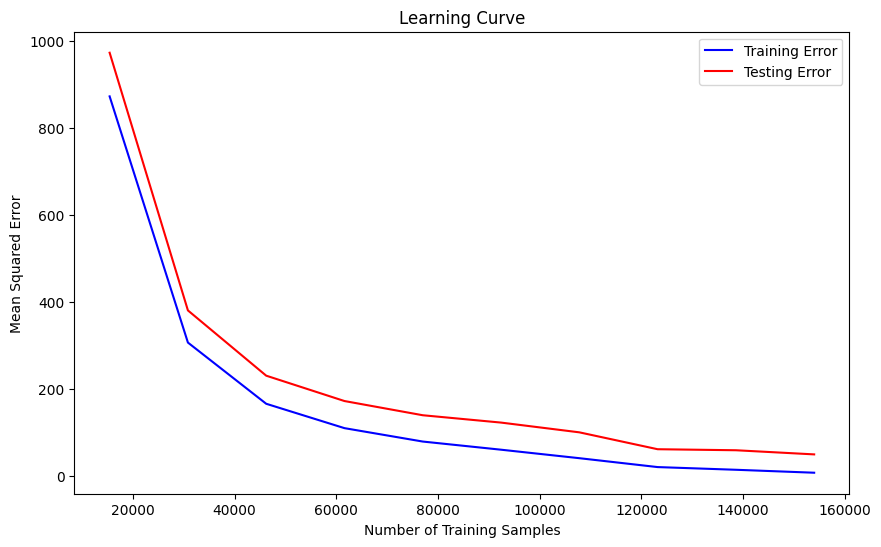

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_sizes * len(X_train), train_errors, label='Training Error', color='blue')
plt.plot(training_sizes * len(X_train), test_errors, label='Testing Error', color='red')
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

# **Predict the azimuth of an antenna**

### Obtain inputs from the user

In [ ]:
longitude_degrees = float(input("Enter the longitude of the new antenna in degrees: "))
latitude_degrees = float(input("Enter the latitude of the new antenna in degrees: "))


Enter the longitude of the new antenna in degrees: 0.3452
Enter the latitude of the new antenna in degrees: 0.7662


### Convert longitude and latitude from degrees to km

In [ ]:
longitude_km = longitude_degrees * 111
latitude_km = latitude_degrees * 111

### Obtain other inputs from the user

In [ ]:
cell_key = int(input("Enter the cell key of the new antenna: "))
mean_rsrp = float(input("Enter the mean_rsrp of the new antenna: "))
instance_count = int(input("Enter the instance count of the new antenna: "))

Enter the cell key of the new antenna: 254567
Enter the mean_rsrp of the new antenna: -105.2
Enter the instance count of the new antenna: 7


### Create a DataFrame with the user inputs

In [ ]:
new_antenna = pd.DataFrame({
    'CELL_KEY_H': [cell_key],
    'MEAN_RSRP': [mean_rsrp],
    'INSTANCE_COUNT': [instance_count],
    'Longitude_km': [longitude_km],
    'Latitude_km': [latitude_km]
})

### Predict the actual azimuth using the model

In [ ]:
predicted_azimuth = rf_regressor.predict(new_antenna)
print('Predicted Azimuth:', predicted_azimuth)


Predicted Azimuth: [162.]


# **Identify antennas that has azimuth difference of more than 30 degrees**

### Calculate predicted_azimuth for all antennas in the dataset

In [ ]:
predicted_azimuth_all = pd.DataFrame({
    'CELL_KEY_H': data['CELL_KEY_H'],
    'Predicted_Azimuth': rf_regressor.predict(data[['CELL_KEY_H', 'MEAN_RSRP', 'INSTANCE_COUNT', 'Longitude_km', 'Latitude_km']])
})

# Print or use the 'predicted_azimuth_all' DataFrame as needed
print(predicted_azimuth_all)




[120. 120. 120. ... 180. 180. 180.]
        CELL_KEY_H  Predicted_Azimuth
0                0              120.0
1                0              120.0
2                0              120.0
3                0              120.0
4                0              120.0
...            ...                ...
192505         109              180.0
192506         109              180.0
192507         109              180.0
192508         109              180.0
192509         109              180.0

[192510 rows x 2 columns]


In [ ]:
average_predicted_azimuths = predicted_azimuth_all.groupby('CELL_KEY_H')['Predicted_Azimuth'].mean()

# Print or use the 'average_predicted_azimuths' as needed
print(average_predicted_azimuths)

CELL_KEY_H
0      120.082699
1      100.227875
2      229.470940
3       20.729695
4      348.955245
          ...    
105    209.810697
106    229.632407
107    179.332750
108     34.984245
109    179.009586
Name: Predicted_Azimuth, Length: 110, dtype: float64


In [ ]:
distinct_cell_key_azimuth = data[['CELL_KEY_H', 'CELL_AZIMUTH']].drop_duplicates()

# Print or use the 'distinct_cell_key_azimuth' DataFrame as needed
print(distinct_cell_key_azimuth)

        CELL_KEY_H  CELL_AZIMUTH
0                0         120.0
1630             1         100.0
2717             2         230.0
4238             3          20.0
5713             4         350.0
...            ...           ...
186102         105         210.0
187794         106         230.0
189414         107         180.0
190843         108          30.0
191446         109         180.0

[110 rows x 2 columns]


### Calculate the difference between predicted_azimuth_all and CELL_AZIMUTH

In [ ]:
merged_data = pd.merge(distinct_cell_key_azimuth, average_predicted_azimuths, on='CELL_KEY_H', how='left')

In [ ]:
merged_data['Azimuth_Difference'] = merged_data['Predicted_Azimuth'] - merged_data['CELL_AZIMUTH']

In [ ]:
print(merged_data)

     CELL_KEY_H  CELL_AZIMUTH  Predicted_Azimuth  Azimuth_Difference
0             0         120.0         120.082699            0.082699
1             1         100.0         100.227875            0.227875
2             2         230.0         229.470940           -0.529060
3             3          20.0          20.729695            0.729695
4             4         350.0         348.955245           -1.044755
..          ...           ...                ...                 ...
105         105         210.0         209.810697           -0.189303
106         106         230.0         229.632407           -0.367593
107         107         180.0         179.332750           -0.667250
108         108          30.0          34.984245            4.984245
109         109         180.0         179.009586           -0.990414

[110 rows x 4 columns]


# Create a new dataset with antennas having an azimuth difference greater than 30

In [ ]:
azimuth_difference_threshold = 30


In [ ]:
filtered_data = merged_data[merged_data['Azimuth_Difference'] > azimuth_difference_threshold]

In [ ]:
print(filtered_data)

Empty DataFrame
Columns: [CELL_KEY_H, CELL_AZIMUTH, Predicted_Azimuth, Azimuth_Difference]
Index: []


In [ ]:
max_azimuth_difference = merged_data['Azimuth_Difference'].max()
print(max_azimuth_difference)

4.984245439469319


# **Save the dataset of the antennas list that has an azimuth difference more than 30 degrees to an Excel file**

In [ ]:
filtered_data.to_excel('antennas_list.xlsx', index=False)

In [ ]:
merged_data.to_excel('antennasListWithDifferences.xlsx', index=False)

# **Comparing Actual azimuths and Predicted azimuths**

### Create the scatter plot


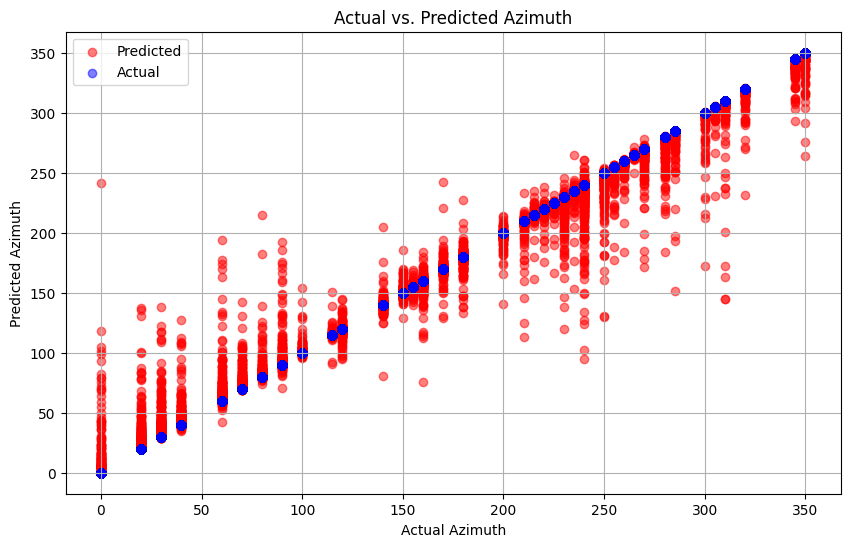

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='red', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.5)
plt.xlabel('Actual Azimuth')
plt.ylabel('Predicted Azimuth')
plt.title('Actual vs. Predicted Azimuth')
plt.legend()
plt.grid(True)
plt.show()

# **Random** **forest** **structure**

### Import the libraries

In [ ]:
from sklearn.tree import plot_tree

### Plot the tree

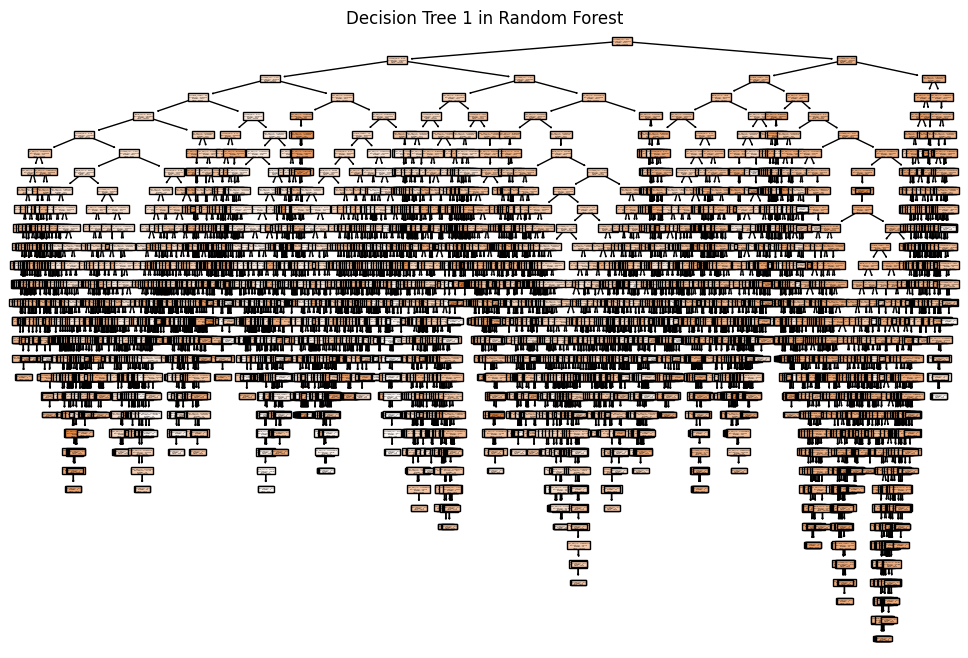

In [ ]:
plt.figure(figsize=(12, 8))

# Structure for the first tree in the forest(Index 0)
tree_to_visualize = 0
feature_names = ['CELL_KEY_H', 'MEAN_RSRP', 'INSTANCE_COUNT', 'Longitude_km', 'Latitude_km']
plot_tree(rf_regressor.estimators_[tree_to_visualize], filled=True, feature_names=feature_names)
plt.title(f"Decision Tree {tree_to_visualize + 1} in Random Forest")
plt.show()